In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [2]:
def Net(input_dim, hidden_dims, output_dim, device):
    model =  nn.Sequential(
        nn.Linear(input_dim, hidden_dims[0]),
        nn.Tanh(),
        nn.BatchNorm1d(hidden_dims[0]),
        nn.Linear(hidden_dims[0], hidden_dims[1]),
        nn.LeakyReLU(),
        nn.BatchNorm1d(hidden_dims[1]),
        nn.Linear(hidden_dims[1], hidden_dims[2]),
        nn.ReLU(),
        nn.Linear(hidden_dims[2], output_dim),
    )
    model.to(device)
    return model

In [3]:
class CustomData(Dataset):
    def __init__(self, X, Y, device, dtype=torch.float32):
        self.X=torch.tensor(X, device=device, dtype=dtype)
        self.Y=torch.tensor(Y, device=device, dtype=dtype)
        self.len=self.X.shape[0]
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

def LoadCustomData(X, Y, device, pca_cutoff=0.1, dtype=torch.float32):
    pca = PCA()
    pca.fit(X)
    count = 0
    for s in pca.singular_values_:
        if s/pca.singular_values_[0] > pca_cutoff:
            count += 1
    pca_trans = PCA(n_components=count)
    pca_trans.fit(X)
    X_trans = pca_trans.transform(X)

    weight = torch.tensor(compute_class_weight('balanced', classes=np.unique(Y), y=Y), device=device, dtype=torch.float32)

    lb = LabelBinarizer()
    Y = lb.fit_transform(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(X_trans, Y)

    
    train_data = CustomData(X_train, Y_train, device, dtype)
    test_data = CustomData(X_test, Y_test, device, dtype)

    return train_data, test_data, weight

In [4]:
def score(model, loader):
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for x, y in loader:
      outputs = model(x)
      predicted = torch.argmax(outputs, 1)
      expected = torch.argmax(y, 1)

      total += y.size(0)

      correct += (predicted == expected).sum()
  accuracy = 100 * correct / total
  return accuracy.item()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df = pd.read_csv('class_train_set.csv', index_col=0)

In [7]:
X = df.drop(columns=['Y'])
Y = df['Y'].apply(lambda x: x-1)

In [8]:
n_epochs = 1000
batch_size = 512
train_data, test_data, weight = LoadCustomData(X.to_numpy(), Y.to_numpy(), device, pca_cutoff=0.01)
train_loader = DataLoader(train_data, batch_size)
test_loader = DataLoader(test_data, batch_size)

In [9]:
input_dim = train_data.X.shape[1]
hidden_dim = [25000, 50, 25000]
output_dim = train_data.Y.shape[1]
model = Net(input_dim, hidden_dim, output_dim, device)
loss_fn = nn.BCEWithLogitsLoss(weight=weight)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [10]:
losses = []

model.train()
for epoch in tqdm(range(n_epochs)):
    for x, y in train_loader:
        optimizer.zero_grad()

        outputs = model.forward(x)
        loss = loss_fn(outputs, y)

        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()

100%|██████████| 1000/1000 [57:13<00:00,  3.43s/it]


In [11]:
train_accuracy = score(model, train_loader)
test_accuracy = score(model, test_loader)
difference = np.abs(train_accuracy - test_accuracy)
print(f'{train_accuracy=}, {test_accuracy=}, {difference=}')

train_accuracy=89.7167739868164, test_accuracy=84.7274398803711, difference=4.9893341064453125


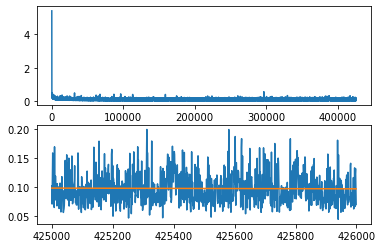

In [12]:
best_fit_cutoff = -1000
fig, ax = plt.subplots(2)
x = range(len(losses))
ax[0].plot(x, losses)
x_cutoff = x[best_fit_cutoff:]
losses_cutoff = losses[best_fit_cutoff:]
ax[1].plot(x_cutoff, losses_cutoff)
best_fit = np.polyfit(x_cutoff, losses_cutoff, 1)
ax[1].plot(x_cutoff, x_cutoff*best_fit[0] + best_fit[1])
plt.show()

In [13]:
torch.save(model.state_dict(), 'parameters.pth')

In [14]:
input_dim

8

In [15]:
output_dim

7

In [16]:
hidden_dim

[25000, 50, 25000]